In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sys, os
from glob import glob 

import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model    
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

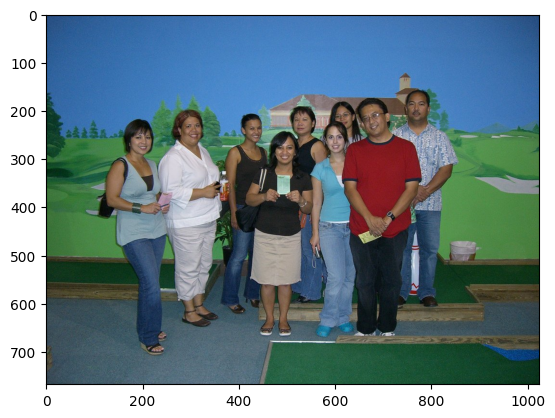

In [4]:
#Dataset from: https://mmspg.epfl.ch/downloads/food-image-datasets/
plt.imshow(image.load_img('tremplin.epfl.ch/FoodImage/Food-5K/training/0_500.jpg'))
plt.show()

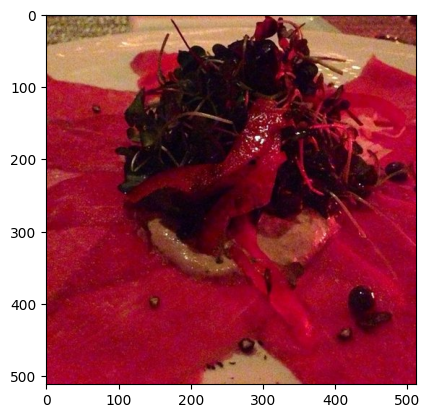

In [6]:
plt.imshow(image.load_img('tremplin.epfl.ch/FoodImage/Food-5K/training/1_500.jpg'))
plt.show()

In [9]:
#Move corresponding images(0*.jpg and 1*.jpg) to data/train/nonfood and data/train/food respectively(similarly repeat for data/test).
train_path = 'data/train/'
valid_path = 'data/test/'

In [8]:
#Resize all images to a smaller size:
IMAGE_SIZE = [200, 200]

In [10]:
#glob returns all matching file paths.
#We find number of samples this way.
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [11]:
#We find number of classes this way.
folders = glob(train_path + '/*')

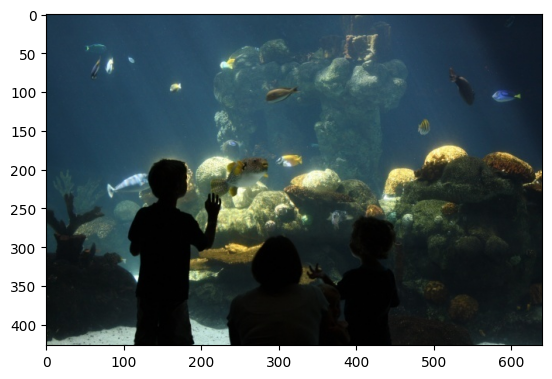

In [12]:
#Check to see if everything works.
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [14]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3], #for the colour channel
    weights = 'imagenet', #import weights trained on the imagenet dataset(by default, weights are initialised randomly for us to train)
    include_top = False #None of the final flatten/dense layers(only upto last convolution layer)
)
#Freeze pretrained model weights
ptm.trainable = False 

58889256/58889256 [==============================] - 148s 3us/step


In [15]:
K = len(folders) #No. of classes
x = Flatten()(ptm.output)
x = Dense(K, activation = 'softmax')(x)
#We use softmax instead of sigmoid because:
#Keras ImageDataGenerator returns classes one-hot encoded(class label becomes feature with 0/1 values).
#Sigmoid simply returns a single output b/w 0-1, and we do not need to calculate other probability without one-hot encoding.
#Since we are making two explicit calculations in one-hot encoded classes, we require softmax, which ensures the sum of the outputs to be 1. 

In [17]:
model = Model(inputs = ptm.input, outputs = x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [19]:
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = preprocess_input #from the vgg16 module
)

In [20]:
batch_size = 128
#create training and validation generators
train_generator = gen.flow_from_directory(
    train_path,
    shuffle = True,
    target_size = IMAGE_SIZE,
    batch_size = batch_size
)
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size
) 

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
model.compile(
    loss = 'categorical_crossentropy', #We don't use sparse since generator one-hot encodes it by default
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [24]:
r = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    steps_per_epoch = int(np.ceil(len(image_files) / batch_size)),
    validation_steps = int(np.ceil(len(valid_image_files) / batch_size))
)

Epoch 1/10
24/24 [==============================] - 101s 3s/step - loss: 1.3306 - accuracy: 0.9283 - val_loss: 1.1363 - val_accuracy: 0.9630
Epoch 2/10
24/24 [==============================] - 30s 1s/step - loss: 0.3948 - accuracy: 0.9790 - val_loss: 0.8625 - val_accuracy: 0.9670
Epoch 3/10
24/24 [==============================] - 30s 1s/step - loss: 0.4060 - accuracy: 0.9813 - val_loss: 0.8572 - val_accuracy: 0.9690
Epoch 4/10
24/24 [==============================] - 30s 1s/step - loss: 0.2422 - accuracy: 0.9860 - val_loss: 0.7102 - val_accuracy: 0.9690
Epoch 5/10
24/24 [==============================] - 30s 1s/step - loss: 0.2055 - accuracy: 0.9890 - val_loss: 1.0968 - val_accuracy: 0.9640
Epoch 6/10
24/24 [==============================] - 31s 1s/step - loss: 0.1614 - accuracy: 0.9907 - val_loss: 0.9040 - val_accuracy: 0.9720
Epoch 7/10
24/24 [==============================] - 31s 1s/step - loss: 0.2133 - accuracy: 0.9863 - val_loss: 0.8223 - val_accuracy: 0.9740
Epoch 8/10
24/24 [=

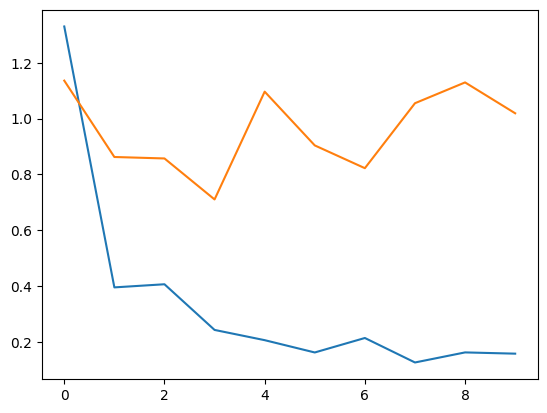

In [25]:
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

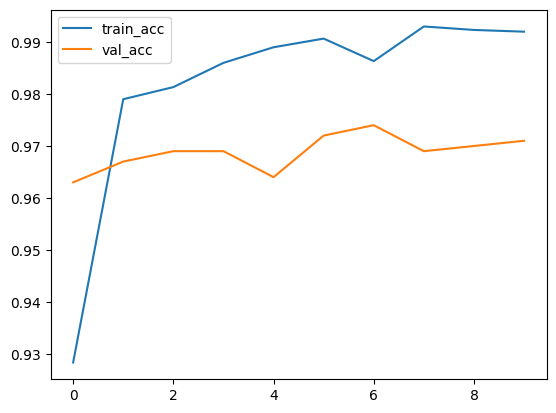

In [26]:
plt.plot(r.history['accuracy'], label = 'train_acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()